## Set Up

In [20]:
#import from python modules:
import cPickle as pickle
import pandas as pd
import numpy as np
from collections import defaultdict
import heapq

import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
with open ('../data/cleaned_df_24NOV17.pkl', 'rb') as f:
    df = pickle.load(f)

## Create New DF with Event Count and Repeat Data for each Person ID

In [22]:
person_event_count_df = df.groupby(by='PersonID').count()

In [23]:
df.groupby(by='PersonID').count().index.values

array([    1,     2,     3, ..., 11669, 11670, 11671])

In [24]:
df.groupby(by='PersonID').count()['EventID'].values

array([1, 2, 1, ..., 1, 1, 1])

In [25]:
repeat_attendees_df = pd.DataFrame.from_dict({'PersonID': person_event_count_df.index.values, 
                                              'Event_Count': person_event_count_df['EventID'].values})

In [26]:
repeat_attendees_df.head()

,Event_Count,PersonID
0,1,1
1,2,2
2,1,3
3,1,4
4,2,5


## Pull and Format Data from Baseline DF to Add to New Repeat Attendees DF

* Event IDs
* Event Dates
* Series IDs
* Calculate lag time between first and second events for those who have attended more than one event ('Repeat Lag Time')
* ID whether a person is one off, repeat within a single series, or repeat across multiple series ('Cross_Series_Attend')

In [27]:
personID_eventID_dict = defaultdict(list)
personID_eventdate_dict = defaultdict(list)
personID_seriesID_dict = defaultdict(list)

for num in person_event_count_df.index.values:
    personID_eventID_dict[num].append(list(df[df['PersonID']==num]['EventID'].values))
    personID_eventdate_dict[num].append(list(df[df['PersonID']==num]['Event_Date'].values))
    personID_seriesID_dict[num].append(list(df[df['PersonID']==num]['SeriesID'].values))

In [28]:
repeat_attendees_df['Event_IDs'] = repeat_attendees_df['PersonID'].map(personID_eventID_dict).apply(lambda x: x[0])
repeat_attendees_df['Event_Dates'] = repeat_attendees_df['PersonID'].map(personID_eventdate_dict).apply(lambda x: x[0])
repeat_attendees_df['Series_IDs'] = repeat_attendees_df['PersonID'].map(personID_seriesID_dict).apply(lambda x: x[0])

In [30]:
def date_trunc(date_list):
    return [np.datetime64(item, 'D') for item in date_list]

In [31]:
repeat_attendees_df['Event_Dates'] = repeat_attendees_df['Event_Dates'].apply(lambda x: date_trunc(x))

In [32]:
def repeat_lag_time(person_ID, duration_days=183):
    if person_ID in repeat_attendees_df['PersonID'].values:
        date_list = sorted(repeat_attendees_df[repeat_attendees_df['PersonID'] == person_ID]['Event_Dates'].values[0])
        if len(date_list) == 1:
            return 'One Off'
        elif len(date_list) > 1:
            first_event, second_event = heapq.nsmallest(2, date_list)
            delta = second_event - first_event
            if delta < np.timedelta64(duration_days, 'D'):
                return 'Under {} days'.format(duration_days)
            else:
                return 'Over {} days'.format(duration_days)
    else:
        print 'Provided PersonID does not exist in the dataframe'

In [33]:
repeat_attendees_df['Repeat_Lag_Time'] = repeat_attendees_df['PersonID'].apply(lambda x: repeat_lag_time(x))

In [34]:
repeat_attendees_df['Cross_Series_Attend'] = repeat_attendees_df['Series_IDs'].apply(lambda x: 
                                            'One Off' if len(x) == 1 else
                                            ('Single - {}'.format(x[0]) if len(set(x)) == 1 else 'Multiple'))

In [35]:
repeat_attendees_df.head()

,Event_Count,PersonID,Event_IDs,Event_Dates,Series_IDs,Repeat_Lag_Time,Cross_Series_Attend
0,1,1,[11],[2015-02-15],[2.0],One Off,One Off
1,2,2,"[9, 17]","[2015-01-24, 2015-06-09]","[1.0, 3.0]",Under 183 days,Multiple
2,1,3,[30],[2015-11-07],[1.0],One Off,One Off
3,1,4,[18],[2015-06-20],[2.0],One Off,One Off
4,2,5,"[13, 40]","[2015-03-14, 2016-04-16]","[0.0, 2.0]",Over 183 days,Multiple


## Get Counts for Single/Repeat Attendees by Type (One Series vs. Multi Series)

In [36]:
total_repeats_count = float(len(repeat_attendees_df[repeat_attendees_df['Event_Count']>1]))
total_repeats_count

2739.0

In [37]:
multi_attend_single_series = repeat_attendees_df[repeat_attendees_df['Cross_Series_Attend'] > 'Single']

In [38]:
single_series = float(len(multi_attend_single_series))
single_series

1241.0

In [39]:
multi_attend_multi_series = repeat_attendees_df[repeat_attendees_df['Cross_Series_Attend'] == 'Multiple']

In [40]:
multi_series = len(multi_attend_multi_series)
multi_series

1498

In [41]:
single_attend = repeat_attendees_df[repeat_attendees_df['Cross_Series_Attend'] == 'One Off']

In [42]:
single_attend_count = len(single_attend)
single_attend_count

8693

In [43]:
total_people = float(len(repeat_attendees_df))
total_people

11432.0

In [44]:
'{}% of attendees are repeat. {}% of repeat attendees have only attended one series \
and {}% have attended multiple'.format(round((single_series+multi_series)/total_people*100), 
                                       round(single_series/total_repeats_count * 100), 
                                       round(multi_series/total_repeats_count * 100))

'24.0% of attendees are repeat. 45.0% of repeat attendees have only attended one series and 55.0% have attended multiple'

In [45]:
multi_attend_single_series_counts = multi_attend_single_series.groupby(by='Cross_Series_Attend')['Event_Count'].count()

In [46]:
multi_attend_single_series_counts.index.values

array(['Single - 0.0', 'Single - 1.0', 'Single - 2.0', 'Single - 3.0',
       'Single - 4.0'], dtype=object)

In [47]:
print 'For the {} Repeat Attendees all in One Series, Breakdown is:'.format(int(single_series))
for idx, val in enumerate(multi_attend_single_series_counts):
    print 'Series {}: {}%'.format(idx, round(val/single_series * 100))

For the 1241 Repeat Attendees all in One Series, Breakdown is:
Series 0: 3.0%
Series 1: 24.0%
Series 2: 45.0%
Series 3: 10.0%
Series 4: 18.0%


## Create New DF Capturing Repeat Attendee Data by Event ID

In [56]:
event_person_count_df = df.groupby(by='EventID').count()

In [57]:
events_df = pd.DataFrame.from_dict({'EventID': event_person_count_df.index.values, 
                                              'Total_Part_Count': event_person_count_df['PersonID'].values})

In [58]:
eventID_personID_dict = defaultdict(list)
eventID_eventdate_dict = defaultdict(list)
eventID_eventname_dict = defaultdict(list)
eventID_seriesID_dict = defaultdict(list)
eventdate_dict = defaultdict(list)
eventname_dict = defaultdict(list)
seriesID_dict = defaultdict(list)

for num in event_person_count_df.index.values:
    eventID_personID_dict[num].append(list(df[df['EventID']==num]['PersonID'].values))
    eventID_eventdate_dict[num].append(list(df[df['EventID']==num]['Event_Date'].values))
    eventID_eventname_dict[num].append(list(df[df['EventID']==num]['Event_Name'].values))
    eventID_seriesID_dict[num].append(list(df[df['EventID']==num]['SeriesID'].values))
    
    eventdate_dict[num] = eventID_eventdate_dict[num][0][0]
    eventname_dict[num] = eventID_eventname_dict[num][0][0]
    seriesID_dict[num] = eventID_seriesID_dict[num][0][0]

In [59]:
events_df['Person_IDs'] = events_df['EventID'].map(eventID_personID_dict).apply(lambda x: x[0])
events_df['Event_Date'] = events_df['EventID'].map(eventdate_dict).apply(lambda x: np.datetime64(x, 'D'))
events_df['Event_Name'] = events_df['EventID'].map(eventname_dict)
events_df['Series_ID'] = events_df['EventID'].map(seriesID_dict)

In [60]:
event_data_dict = defaultdict(list)
for event in events_df['EventID'].values:
    repeats_singleseries = 0
    repeats_multiseries = 0
    single_attend = 0
    first_timer = 0
    under_six_month_repeat = 0
    over_six_month_repeat = 0
    first_timer_ids = list()
    for person in events_df[events_df['EventID'] == event]['Person_IDs'].values[0]:
        att_status = repeat_attendees_df[repeat_attendees_df['PersonID'] == person]['Cross_Series_Attend'].values[0]
        lag_status = repeat_attendees_df[repeat_attendees_df['PersonID'] == person]['Repeat_Lag_Time'].values[0]
        if att_status == 'Multiple':
            repeats_multiseries += 1
        elif att_status == 'One Off':
            single_attend += 1
        else:
            repeats_singleseries += 1
            
        if min(repeat_attendees_df[repeat_attendees_df['PersonID']==person]['Event_Dates'].values[0]) == events_df[
            events_df['EventID']==event]['Event_Date'].values[0]:
            first_timer += 1
            first_timer_ids.append(person)
            if lag_status == 'Under 183 days':
                under_six_month_repeat += 1
            elif lag_status == 'Over 183 days':
                over_six_month_repeat += 1
            
    event_data_dict['repeat_singleseries'].append(repeats_singleseries)
    event_data_dict['repeat_multiseries'].append(repeats_multiseries)
    event_data_dict['single_attend'].append(single_attend)
    event_data_dict['first_timer'].append(first_timer)
    event_data_dict['six_mo_repeat'].append(under_six_month_repeat)
    event_data_dict['longer_repeat'].append(over_six_month_repeat)
    event_data_dict['first_timer_ids'].append(first_timer_ids)

In [61]:
events_df['Repeat_SingleSeries'] = event_data_dict['repeat_singleseries']
events_df['Repeat_MultiSeries'] = event_data_dict['repeat_multiseries']
events_df['Single_Attend'] = event_data_dict['single_attend']
events_df['First_Timers'] = event_data_dict['first_timer']
events_df['First_Timer_IDs'] = event_data_dict['first_timer_ids']
events_df['Repeat_Under_Six_Mo'] = event_data_dict['six_mo_repeat']
events_df['Repeat_Over_Six_Mo'] = event_data_dict['longer_repeat']

In [62]:
events_df.sort_values(by='Event_Date', ascending=True, inplace=True)

In [63]:
events_df['%_Repeat_Under_Six'] = 100 * events_df['Repeat_Under_Six_Mo'] / (events_df['First_Timers'])
events_df['%_Repeat_Under_Six'] = events_df['%_Repeat_Under_Six'].apply(lambda x: int(x))

events_df['%_Repeat_Over_Six'] = 100 * events_df['Repeat_Over_Six_Mo'] / (events_df['First_Timers'])
events_df['%_Repeat_Over_Six'] = events_df['%_Repeat_Over_Six'].apply(lambda x: int(x))

In [64]:
events_df.reset_index(drop=True, inplace=True)

In [121]:
events_df.head()

,EventID,Total_Part_Count,Person_IDs,Event_Date,Event_Name,Series_ID,Repeat_SingleSeries,Repeat_MultiSeries,Single_Attend,First_Timers,First_Timer_IDs,Repeat_Under_Six_Mo,Repeat_Over_Six_Mo,%_Repeat_Under_Six,%_Repeat_Over_Six
0,1000,160,"[5515, 5516, 5517, 5518, 5519, 5520, 5521, 552...",2014-12-13,Market Scramble 2014,4.0,54,9,97,160,"[5515, 5516, 5517, 5518, 5519, 5520, 5521, 552...",31,32,19,20
1,8,223,"[11, 68, 97, 105, 122, 136, 159, 165, 171, 172...",2015-01-04,Absolution Run,1.0,31,85,107,221,"[11, 68, 97, 105, 122, 136, 159, 165, 171, 172...",88,26,39,11
2,9,275,"[2, 14, 19, 51, 66, 78, 89, 98, 109, 128, 149,...",2015-01-24,Interlaken Icicle Dash,1.0,40,95,140,234,"[2, 14, 19, 51, 66, 78, 89, 98, 109, 128, 149,...",67,27,28,11
3,10,303,"[10, 14, 19, 20, 21, 30, 62, 79, 87, 90, 119, ...",2015-02-07,Frost Eagle,1.0,34,119,150,223,"[10, 20, 21, 30, 62, 79, 87, 90, 119, 129, 131...",37,36,16,16
4,11,353,"[1, 15, 27, 35, 38, 39, 57, 65, 66, 67, 75, 83...",2015-02-15,Fort Ebey Kettles Trail Run,2.0,68,88,197,323,"[1, 15, 27, 35, 38, 39, 57, 65, 67, 75, 83, 10...",62,64,19,19


In [125]:
np.argmax(events_df[events_df['Event_Date'] <= pd.to_datetime('today') 
                    - np.timedelta64(183, 'D')]['Event_Date'].values) + 1

80

In [126]:
six_mo_backoff = max(date_trunc(events_df['Event_Date'].values)) - np.timedelta64(183, 'D')

np.argmax(events_df[events_df['Event_Date'] <= six_mo_backoff]['Event_Date'].values) + 1

74

In [173]:
def series_decoder(series_id):
    series_decoder_dict = {0.0 : 'No Series', 1.0 : 'Winter Series', 2.0 : 'Half Marathon Series', 
                      3.0 : 'Summer Series', 4.0 : 'Street Scramble'}
    
    return series_decoder_dict[series_id]

In [174]:
series_decoder(3.0)

'Summer Series'

In [209]:
def max_index():
    six_mo_backoff = max(date_trunc(events_df['Event_Date'].values)) - np.timedelta64(183, 'D')
    max_index = np.argmax(events_df[events_df['Event_Date'] <= six_mo_backoff]['Event_Date'].values) + 1
    
    return max_index

In [210]:
def define_xy_dataset(timeframe, events_df):
    
    max_idx = max_index()
    
    X = events_df['Event_Date'].iloc[0:max_idx].values #include data thru 6 mo prior to latest event date
        
    if timeframe == 'all':
        Y = events_df['%_Repeat_Over_Six'].iloc[0:max_idx].values + \
        events_df['%_Repeat_Under_Six'].iloc[0:max_idx].values
        title_input = 'at Any Time'
    elif timeframe == 'over':
        Y = events_df['%_Repeat_Over_Six'].iloc[0:max_idx].values
        title_input = 'Over 6 Months Later'
    elif timeframe == 'under':
        Y = events_df['%_Repeat_Under_Six'].iloc[0:max_idx].values
        title_input = 'Within 6 Months'
    else:
        raise ValueError("Invalid Value for timeframe.  Select 'over', 'under', or 'all'")
        
    return max_idx, X, Y, title_input

In [211]:
def plot_percent_returners(timeframe, events_df, waterline):
    '''timeframe is either 'over', 'under', or 'all' to indicate whether to plot returners in under 6 months, 
    over 6 months, or all returners; events_df is the dataframe to plot from; waterline is where to draw the line on 
    what % level is considered significant for further investigation.'''
    
    fig, ax = plt.subplots(figsize=(24,12))
    
    max_idx, X, Y, title_input = define_xy_dataset(timeframe, events_df)
        
    Names = events_df['Event_Name'].iloc[0:max_idx].values
    Series = events_df['Series_ID'].iloc[0:max_idx].values
    EventID = events_df['EventID'].iloc[0:max_idx].values
    EventDate = date_trunc(events_df['Event_Date'].iloc[0:max_idx].values)

    ax.plot(X,Y);
    ax.set_title('% of First Timers at Each Event That Have Returned {}'.format(title_input), size=20);

    ax.hlines(y = waterline, xmin=events_df['Event_Date'][0], xmax=events_df['Event_Date'][max_idx], color='r');

    for x,y,n,sr, e, d in zip(X, Y, Names, Series, EventID, EventDate):
        if y > waterline:
            sr = series_decoder(sr)
            ax.annotate(s = '{}, {}%'.format(n, y), xy=(x,y), xytext=(x,y), size=15,  
                        verticalalignment='bottom', horizontalalignment = 'left', rotation = 0)
            print ('Event #{}, {}: \n \t {}, Series {}, {}%'.format(e, d, n, sr, y))

Event #8, 2015-01-04: 
 	 Absolution Run, Series Winter Series, 39%
Event #13, 2015-03-14: 
 	 Cedar Mountain Trail Run, Series No Series, 45%
Event #17, 2015-06-09: 
 	 Ravenna Run the Ravine, Series Summer Series, 34%
Event #23, 2015-08-11: 
 	 Summer Eddy, Series Summer Series, 36%
Event #30, 2015-11-07: 
 	 Carkeek Cooler, Series Winter Series, 39%
Event #31, 2015-11-21: 
 	 Ravenna Refresher, Series Winter Series, 42%
Event #43, 2016-05-10: 
 	 Woodland Park Zoom, Series Summer Series, 45%
Event #44, 2016-05-24: 
 	 Wilburton Hillbilly, Series Summer Series, 58%
Event #48, 2016-06-21: 
 	 Sunshine Salutation, Series Summer Series, 64%
Event #60, 2016-11-05: 
 	 Ravenna Refresher, Series Winter Series, 40%


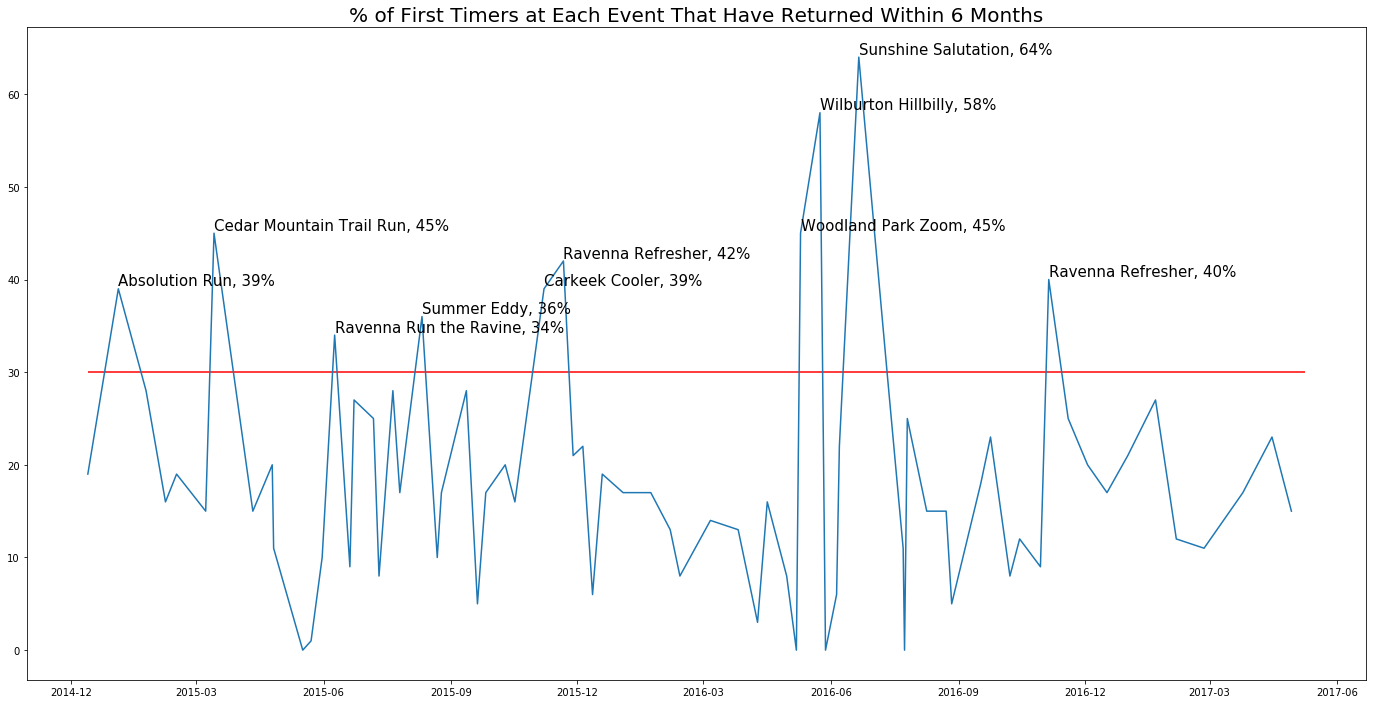

In [212]:
plot_percent_returners('under', events_df, 30)

In [74]:
sum(events_df['First_Timers'].iloc[0:80].values) / float(sum(events_df['Total_Part_Count'].iloc[0:80].values)) * 30

19.169293528648247

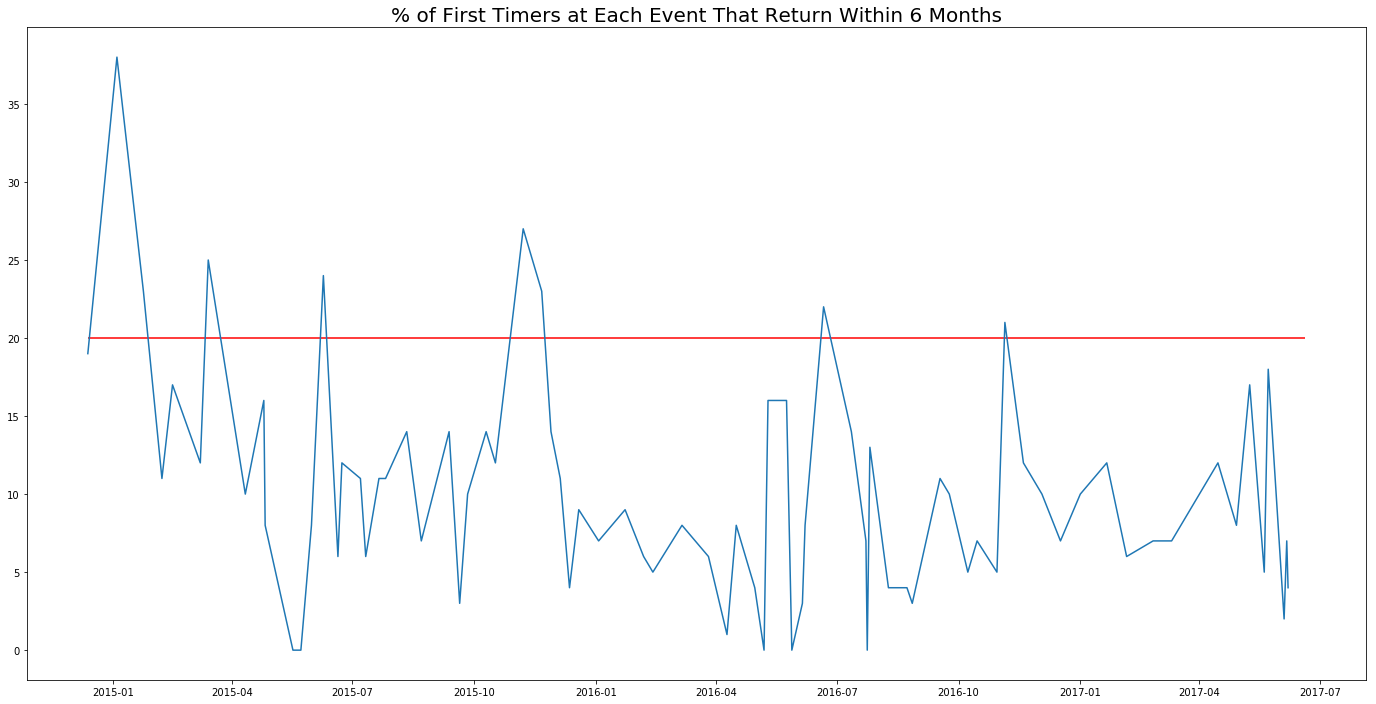

In [75]:
#if repeat the above plot but normalize for number of first timers relative to size of event:

fig, ax = plt.subplots(figsize=(24,12))

X = events_df['Event_Date'].iloc[0:80].values #include data through June 7th 2017; 6 months ago
Y = events_df['%_Repeat_Under_Six'].iloc[0:80].values * events_df['First_Timers'].iloc[0:80].values / events_df['Total_Part_Count'].iloc[0:80].values
Names = events_df['Event_Name'].iloc[0:80].values
Series = events_df['Series_ID'].iloc[0:80].values
EventID = events_df['EventID'].iloc[0:80].values

ax.plot(X,Y);
ax.set_title('% of First Timers at Each Event That Return Within 6 Months', size=20);

ax.hlines(y = 20, xmin=events_df['Event_Date'][0], xmax=events_df['Event_Date'][80], color='r');

#for x,y,n,s, e in zip(X, Y, Names, Series, EventID):
#    ax.annotate(s = '{}, {}, {}, {}%'.format(n, s, e, y), xy=(x,y), xytext=(x,y), size=15)

### Event Instances with High % of First Timers Returning in Next 6 Months When Normalized for Number of First Timers at Event ( > 20%):

#### 2015:
* Absolution Run, ID 8, 38%, Winter Series
* Interlaken Icicle Dash, ID 9, 23%, Winter Series
* Cedar Mountain Trail Run, ID 13, 25%, No Series
* Ravenna Run the Ravine, ID 17, 24%, Summer Series
* Carkeek Cooler, ID 30, 27%, Winter Series
* Ravenna Refresher, ID 31, 23%, Winter Series

Drops Out: Summer Eddy, ID 23, Summer Series

#### 2016:
* Sunshine Salutation, ID 48, 22%, Summer Series
* Ravenna Refresher, ID 60, 21%, Winter Series

Drops Out: Woodland Park Zoom, ID 43, Summer Series; Wilburton Hillbilly, ID 44, Summer Series

#### 2017:
* None meet 20% threshold

Drops Out: Woodland Park Zoom, ID 73, Summer Series; Wilburton Hilbilly, ID 75, Summer Series

### Look at an Individual Event with High Rate of Return of First Timers:

In [185]:
events_df[events_df['EventID']==48]

,EventID,Total_Part_Count,Person_IDs,Event_Date,Event_Name,Series_ID,Repeat_SingleSeries,Repeat_MultiSeries,Single_Attend,First_Timers,First_Timer_IDs,Repeat_Under_Six_Mo,Repeat_Over_Six_Mo,%_Repeat_Under_Six,%_Repeat_Over_Six
49,48,71,"[85, 184, 582, 662, 729, 796, 865, 868, 894, 9...",2016-06-21,Sunshine Salutation,3.0,12,53,6,25,"[5735, 5736, 5737, 5738, 5739, 5741, 5742, 574...",16,3,64,12


In [186]:
def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    return [np.nan if x==0 else x for x in values]

In [187]:
def single_event_future_repeats(event_id):
    '''Create dataframe for counts of when first timers at a given event have their first repeat attendance, based on 
    perspective of event with provided event_id'''
    idx = (events_df[events_df['EventID']==event_id].index.values[0]) + 1
    event_person_list = events_df[events_df['EventID']==event_id]['First_Timer_IDs'].values[0]
    future_events_df = events_df[['Event_Name', 'EventID', 'Event_Date', 'Series_ID']].iloc[idx:]
    already_repeated_list = list()
    event_future_repeats_list = list()
    
    for event in future_events_df['EventID'].values:
        repeat_att = 0
        for person in events_df[events_df['EventID']==event]['Person_IDs'].values[0]:
            if person in event_person_list and person not in already_repeated_list:
                repeat_att += 1
                already_repeated_list.append(person)
        event_future_repeats_list.append(repeat_att)
    
    future_events_df['Repeats'] = zero_to_nan(event_future_repeats_list)
    
    return future_events_df

In [188]:
def plot_single_event_future_repeats(event_id_list):
    
    subplot_size = len(event_id_list)
    fig, axes = plt.subplots(subplot_size, 1, figsize=(20,30))
    
    for ax, event_id in zip(axes.flatten(), event_id_list):
        event_futurerepeats_df = single_event_future_repeats(event_id)
        X = event_futurerepeats_df['Event_Date'].values
        Y = event_futurerepeats_df['Repeats'].values
        ymax = np.nanmax(Y) + np.nanmax(Y) / 2
        ymin = np.nanmin(Y) / 10
        Names = event_futurerepeats_df['Event_Name'].values
        Series = event_futurerepeats_df['Series_ID'].values
        
        ax.scatter(X,Y);
        ax.set_title('Spread of First Repeat for First Timers at Event #{}, {}'.format(
            event_id,events_df[events_df['EventID']==event_id]['Event_Name'].values[0]), size=13);
        ax.set_xlabel('Event Date')
        ax.set_ylabel('Number of Attendees')
        ax.set_ylim((ymin, ymax))
        
        for x,y,n,s in zip(X, Y, Names, Series):
            ax.annotate(s = '{}'.format(n), xy=(x,y), xytext=(x,y), verticalalignment='bottom', 
                       horizontalalignment = 'left', rotation = 60)
            
        textstr = 'Total Event Size: {} \n First Timers: {}'.format(
            events_df[events_df['EventID']==event_id]['Total_Part_Count'].values[0], 
            events_df[events_df['EventID']==event_id]['First_Timers'].values[0], 
            events_df[events_df['EventID']==event_id])
        
        #these are matplotlib.path.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        
        #place a text box in the upper left in axes coords
        ax.text(0.85, 0.96, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

In [213]:
def get_events_of_interest(timeframe, events_df, waterline):
    
    max_idx = max_index()
    
    if timeframe == 'all':
        eventIDs = events_df[(
            events_df['%_Repeat_Under_Six'] + events_df['%_Repeat_Over_Six']) > waterline][
            'EventID'].iloc[0:max_idx].values
    elif timeframe == 'over':
        eventIDs = events_df[events_df['%_Repeat_Over_Six'] > waterline]['EventID'].iloc[0:max_idx].values
    elif timeframe == 'under':
        eventIDs = events_df[events_df['%_Repeat_Under_Six'] > waterline]['EventID'].iloc[0:max_idx].values
    else:
        raise ValueError("Invalid Value for timeframe.  Select 'over', 'under', or 'all'")
    
    return eventIDs

Event #13, 2015-03-14: 
 	 Cedar Mountain Trail Run, Series No Series, 45%
Event #31, 2015-11-21: 
 	 Ravenna Refresher, Series Winter Series, 42%
Event #43, 2016-05-10: 
 	 Woodland Park Zoom, Series Summer Series, 45%
Event #44, 2016-05-24: 
 	 Wilburton Hillbilly, Series Summer Series, 58%
Event #48, 2016-06-21: 
 	 Sunshine Salutation, Series Summer Series, 64%


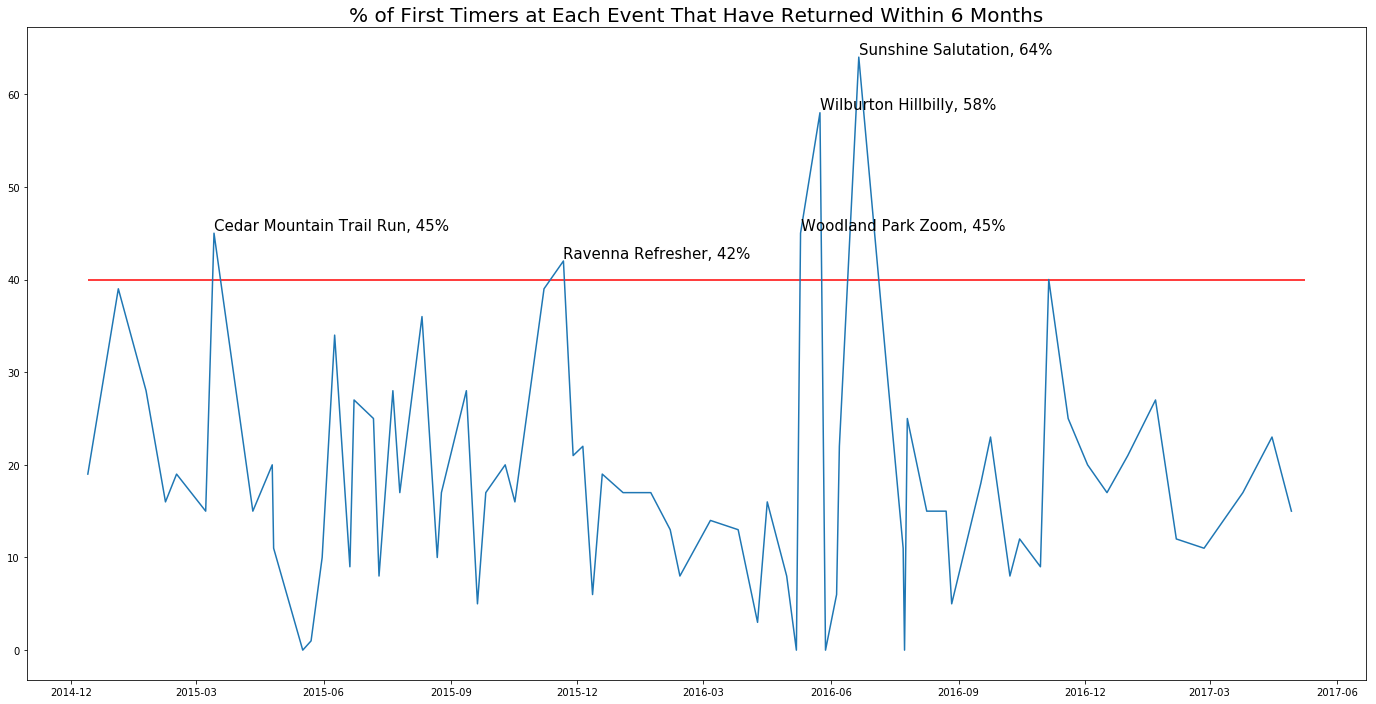

In [220]:
plot_percent_returners('under', events_df, 40)

In [218]:
list_of_events = get_events_of_interest('under', events_df, 40)

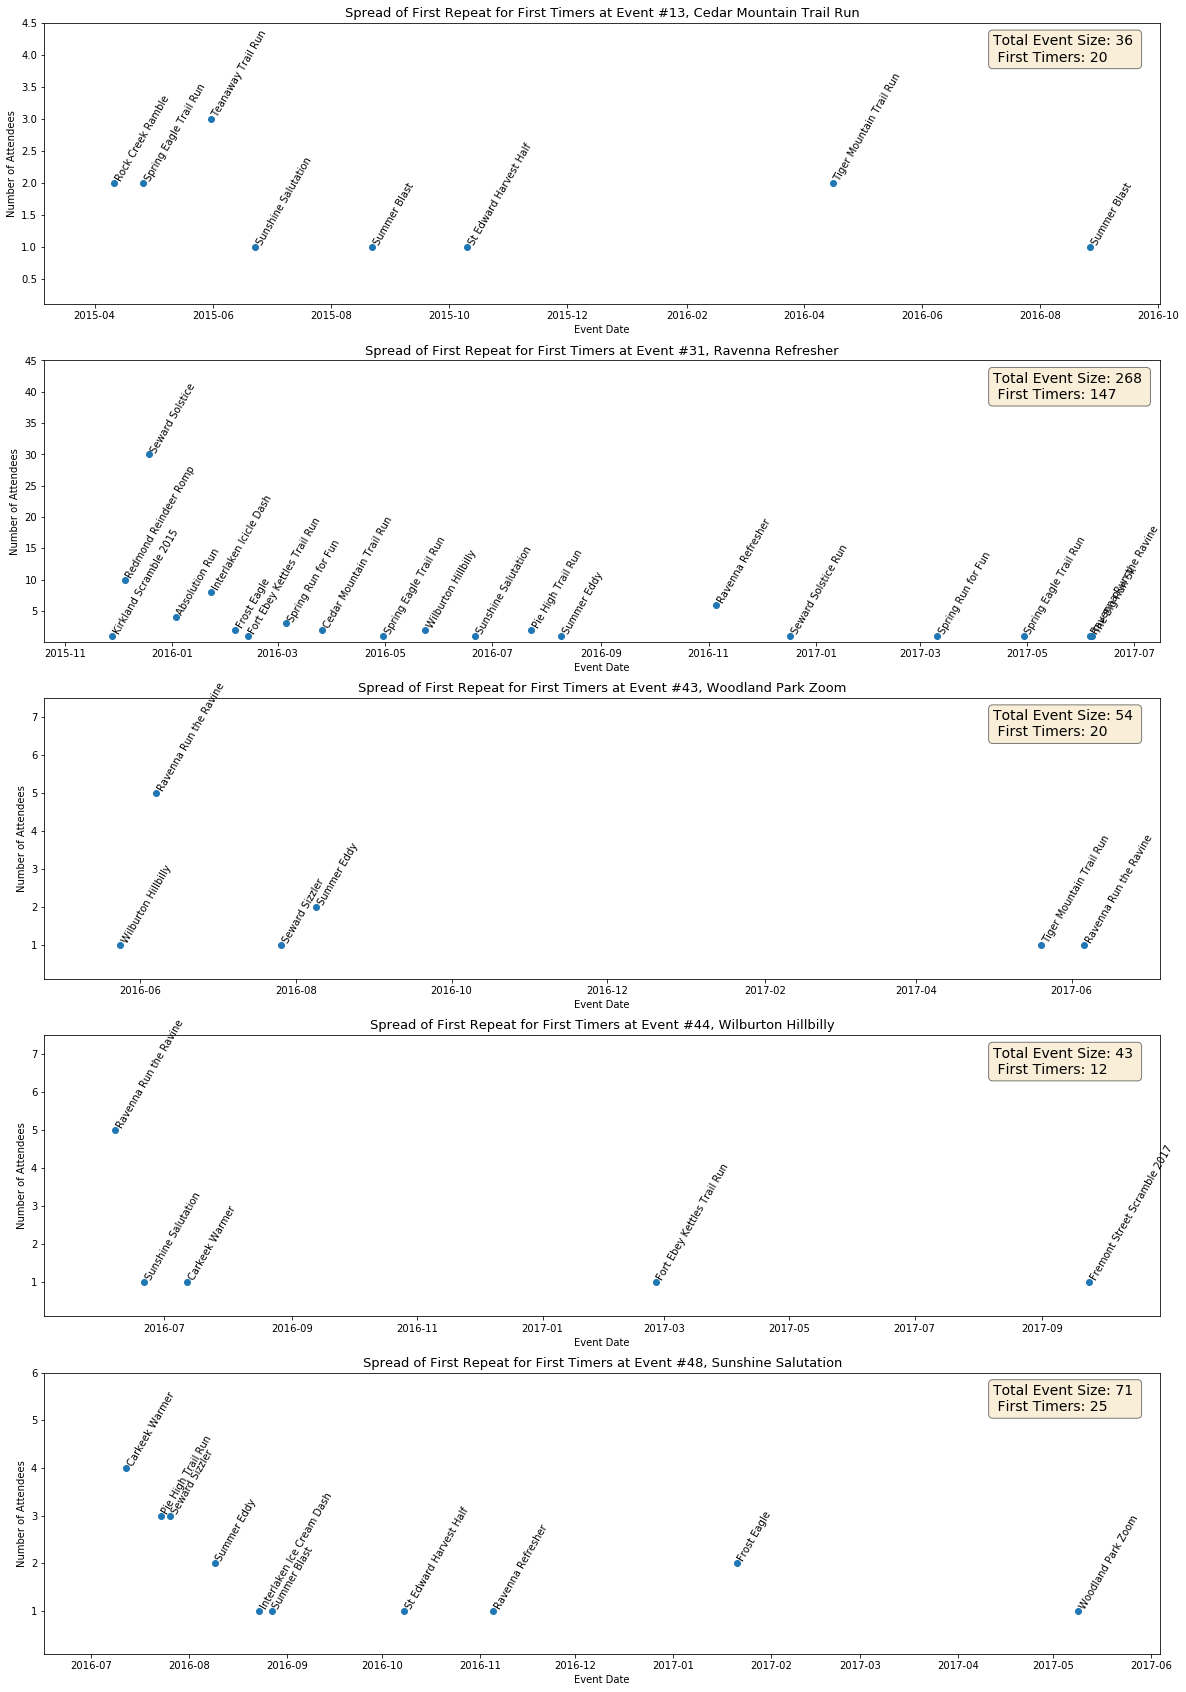

In [219]:
plot_single_event_future_repeats(list_of_events)